**Table of contents:**

1. [Data Wrangling](#data-wrangling)<br><br>
2. [EDA: Exploration Data Analysis](#eda-exploration-data-analysis)<br><br>
3. [RFM as Behavioral Segmentation](#rfm-as-behavioral-segmentation )<br><br>

In [1]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pycountry
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

# Define rcParams settings as a dictionary
plot_settings = {
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
}

# Apply the settings globally
plt.rcParams.update(plot_settings)

## Data Wrangling

In [4]:
df = pd.read_csv('DS Assignment_Dataset.csv')

In [5]:
df.head(5).T

,0,1,2,3,4
REGISTRATION_DATE,2020-09-01 00:00:00,2020-09-01 00:00:00,2020-09-01 00:00:00,2020-09-01 00:00:00,2020-09-01 00:00:00
REGISTRATION_COUNTRY,SWE,NOR,SWE,NOR,GEO
PURCHASE_COUNT,0,1,19,0,0
PURCHASE_COUNT_DELIVERY,NaN,1.00,19.00,NaN,NaN
PURCHASE_COUNT_TAKEAWAY,NaN,0.00,0.00,NaN,NaN
FIRST_PURCHASE_DAY,NaN,2021-09-02 00:00:00,2020-12-10 00:00:00,NaN,NaN
LAST_PURCHASE_DAY,NaN,2021-09-02 00:00:00,2021-05-25 00:00:00,NaN,NaN
USER_ID,1,2,3,4,5
BREAKFAST_PURCHASES,NaN,0.00,0.00,NaN,NaN
LUNCH_PURCHASES,NaN,1.00,4.00,NaN,NaN


In [6]:
# generating the lowercase column names
df.columns = df.columns.str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21983 entries, 0 to 21982
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   registration_date                        21983 non-null  object 
 1   registration_country                     21983 non-null  object 
 2   purchase_count                           21983 non-null  int64  
 3   purchase_count_delivery                  12028 non-null  float64
 4   purchase_count_takeaway                  12028 non-null  float64
 5   first_purchase_day                       11948 non-null  object 
 6   last_purchase_day                        12009 non-null  object 
 7   user_id                                  21983 non-null  int64  
 8   breakfast_purchases                      12028 non-null  float64
 9   lunch_purchases                          12028 non-null  float64
 10  evening_purchases                        12028

In [8]:
# converting each element from a JSON string to a Python dictionary using the json.loads function.
df['purchase_count_by_store_type'] = df['purchase_count_by_store_type'].apply(json.loads)

In [9]:
# Now explanding 
categories_expanded = pd.json_normalize(df['purchase_count_by_store_type'])

In [10]:
# Renaming the columns in a more convenient format
categories_expanded.rename(columns={'General merchandise': 'general_merchandise', 
                           'Pet supplies': 'pet_supplies',
                           'Retail store': 'retail_store',
                           'Restaurant': 'restaurant',
                           'Grocery': 'grocery'}, inplace=True)

In [11]:
# Concatenate with the original DataFrame
df = pd.concat([df.drop('purchase_count_by_store_type', axis=1), categories_expanded], axis=1)

In [12]:
# Sum of duplicated rows
df.duplicated().sum()

0

In [13]:
# converting string element to list of strings
df['preferred_restaurant_types'] = df['preferred_restaurant_types'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

In [14]:
df[df['preferred_restaurant_types'].notnull()].preferred_restaurant_types

13                [american]
16                [american]
17                [japanese]
26                 [italian]
31                [american]
                ...         
21921              [mexican]
21923             [american]
21929              [chinese]
21947              [italian]
21969    [american, italian]
Name: preferred_restaurant_types, Length: 2694, dtype: object

In [15]:
# Mapping ISO alpha-3 country codes to country name
def get_country_name(alpha_3_code):
    country = pycountry.countries.get(alpha_3=alpha_3_code)
    return country.name if country else None

In [16]:
df['registration_country_name'] = df.registration_country.apply(get_country_name)

In [17]:
df.registration_country_name.head(5)

0     Sweden
1     Norway
2     Sweden
3     Norway
4    Georgia
Name: registration_country_name, dtype: object

In [18]:
# Changing the date object to a datetime type
for date_obj in ['registration_date', 'first_purchase_day', 'last_purchase_day']:
    df[date_obj] = pd.to_datetime(df[date_obj])

In [19]:
# Changing the float to time type

In [20]:
df['most_common_hour_of_the_day_to_purchase'] = pd.to_datetime(df.most_common_hour_of_the_day_to_purchase, 
                                                               format='%H').dt.time

In [21]:
df[df['most_common_hour_of_the_day_to_purchase'].notnull()]\
.most_common_hour_of_the_day_to_purchase.head()

1     23:00:00
2     21:00:00
7     05:00:00
12    07:00:00
13    05:00:00
Name: most_common_hour_of_the_day_to_purchase, dtype: object

In [22]:
df['day_difference_between_first_last_purchase'] = (df['last_purchase_day'] - df['first_purchase_day']).dt.days

In [23]:
df.registration_country_name.nunique()

59

In [24]:
# calculate the user share for each country
df.groupby('registration_country_name').user_id.nunique().sort_values(ascending=False).cumsum()/\
df.user_id.nunique()

registration_country_name
Norway                      0.47
Sweden                      0.84
Georgia                     0.97
United States               0.98
United Kingdom              0.98
Denmark                     0.98
Estonia                     0.98
Germany                     0.98
Finland                     0.99
Italy                       0.99
Poland                      0.99
Lithuania                   0.99
Spain                       0.99
Czechia                     0.99
France                      0.99
Hungary                     0.99
Australia                   0.99
Belgium                     0.99
Netherlands                 0.99
Israel                      0.99
Russian Federation          0.99
Brazil                      0.99
Cyprus                      0.99
India                       1.00
Ireland                     1.00
Latvia                      1.00
Canada                      1.00
Qatar                       1.00
United Arab Emirates        1.00
Japan            

In the following analysis we will focus only on Norway, Sweden and Georgia whose user share sum represents already the ~97% of the entire data.

In [25]:
df1 = df.loc[df.registration_country.isin(['SWE', 'NOR', 'GEO'])]

In [26]:
# Calculating the share of not null values within a column for each country

share_non_null = df1.groupby('registration_country').apply(lambda x: x.notnull().mean())

In [27]:
share_non_null.T

registration_country,GEO,NOR,SWE
registration_date,1.00,1.00,1.00
registration_country,1.00,1.00,1.00
purchase_count,1.00,1.00,1.00
purchase_count_delivery,0.50,0.53,0.62
purchase_count_takeaway,0.50,0.53,0.62
first_purchase_day,0.50,0.53,0.61
last_purchase_day,0.50,0.53,0.62
user_id,1.00,1.00,1.00
breakfast_purchases,0.50,0.53,0.62
lunch_purchases,0.50,0.53,0.62


In [28]:
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
registration_date,21400,2020-09-15 11:36:55.177570304,2020-09-01 00:00:00,2020-09-08 00:00:00,2020-09-15 00:00:00,2020-09-22 00:00:00,2020-09-30 00:00:00,NaN
purchase_count,"21,400.00",3.42,0.00,0.00,1.00,3.00,320.00,8.61
purchase_count_delivery,"11,968.00",5.75,0.00,1.00,2.00,6.00,320.00,10.55
purchase_count_takeaway,"11,968.00",0.37,0.00,0.00,0.00,0.00,44.00,1.42
first_purchase_day,11888,2020-11-22 06:54:01.453566464,2020-09-01 00:00:00,2020-09-14 00:00:00,2020-09-26 00:00:00,2020-12-28 00:00:00,2021-10-31 00:00:00,NaN
last_purchase_day,11949,2021-04-19 03:39:27.160431872,2020-09-01 00:00:00,2020-10-11 00:00:00,2021-05-22 00:00:00,2021-09-27 00:00:00,2021-10-31 00:00:00,NaN
user_id,"21,400.00","11,000.49",1.00,"5,499.75","11,002.50","16,485.25","21,983.00","6,346.33"
breakfast_purchases,"11,968.00",0.19,0.00,0.00,0.00,0.00,52.00,1.11
lunch_purchases,"11,968.00",2.38,0.00,0.00,1.00,2.00,171.00,5.64
evening_purchases,"11,968.00",0.49,0.00,0.00,0.00,0.00,71.00,1.83


In [29]:
# share of users for each country
df1.groupby('registration_country_name').user_id.nunique()/\
df1.user_id.nunique()

registration_country_name
Georgia   0.14
Norway    0.48
Sweden    0.38
Name: user_id, dtype: float64

The main contributors to the following analysis are Norway (representing 48% of the data) and Sweden (38%). Georgia reflects only the 14% of the selected dataset. 

## EDA: Exploration Data Analysis

In [30]:
# identyfying the users who purchase and not purchase 
df1['purchasing_users'] = np.where(df1.purchase_count>0, True, False)

In [31]:
# calculating the share of purchasing users in the dataset
(df1[df1.purchasing_users==True].user_id.nunique()/\
df1.user_id.nunique())*100

55.925233644859816

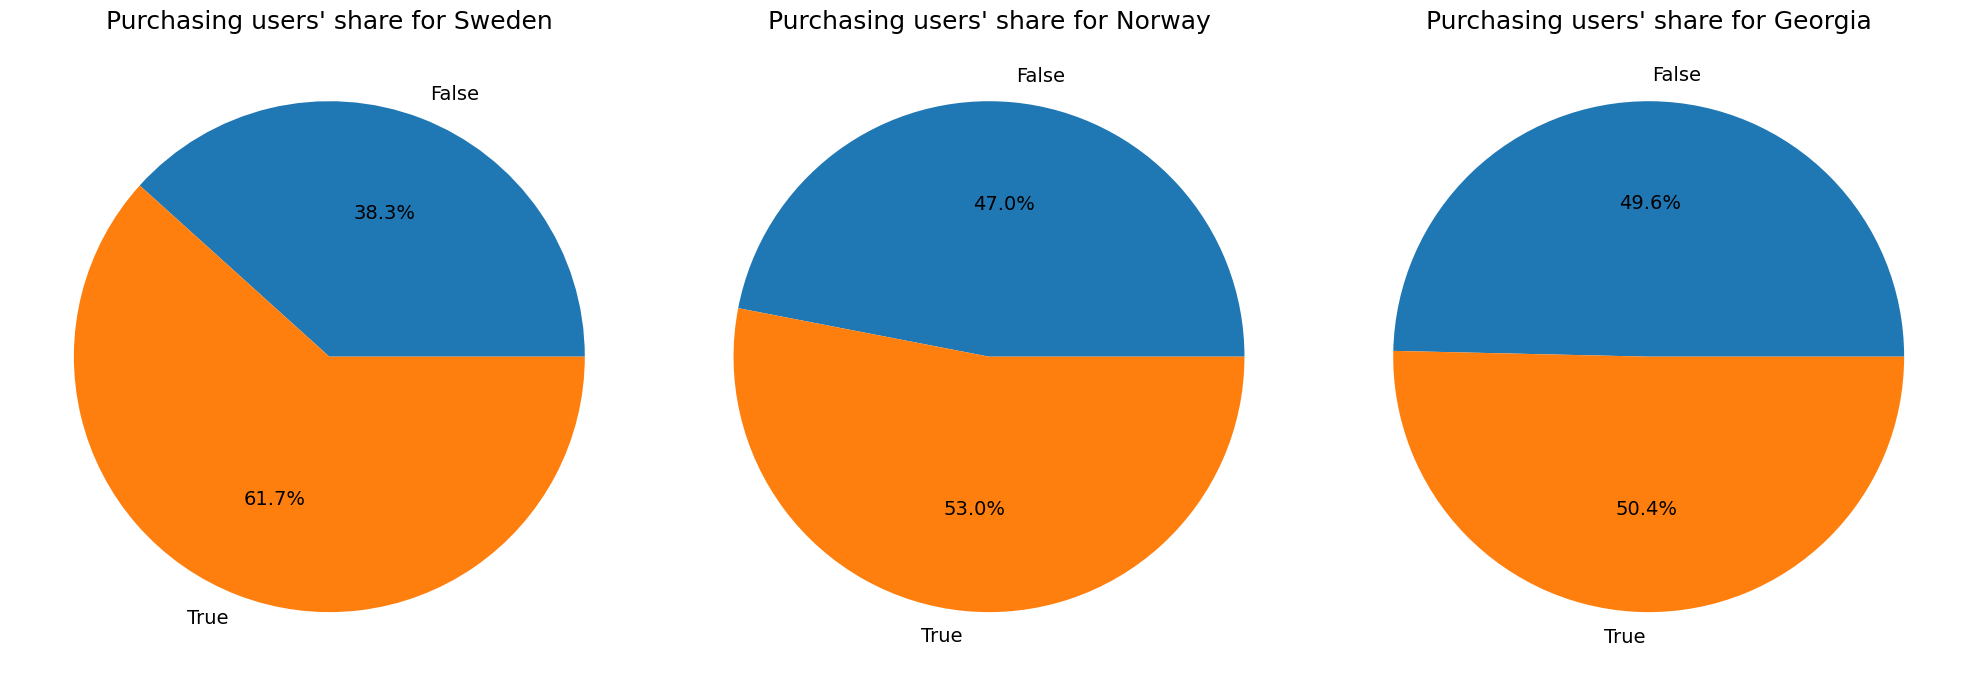

In [32]:
# creating the graph
countries = df1['registration_country_name'].unique()
fig, axes = plt.subplots(1,len(countries), figsize=(20, 10))

# Ensure axes is iterable even for a single subplot
if len(countries) == 1:
    axes = [axes]

for i, country in enumerate(countries):
    ax = axes[i]
    country_data = df1[df1['registration_country_name'] == country]

    # Calculate the sum of purchases
    sums = country_data.groupby(['purchasing_users']).user_id.nunique()
    
    # Plot pie chart
    ax.pie(
        sums.values,
        labels=sums.index,
        autopct='%1.1f%%')
           
    ax.set_title(f"Purchasing users' share for {country}", fontsize=18)

plt.tight_layout()
plt.show()

Overall, from September 2020 until October 2021 the purchasing share is of ~56%. By looking at each country separately, Sweden has the highest purchasing share (61.7%) compared to Norway and Georgia, for which the purchasing share is if ~53% and 50.4% respectively.

In [33]:
# calculating the share of users having a valid a payment method for non- and purchasing users
df1.groupby(['purchasing_users']).user_has_valid_payment_method.value_counts(normalize=True)

purchasing_users  user_has_valid_payment_method
False             False                           0.95
                  True                            0.05
True              True                            0.59
                  False                           0.41
Name: proportion, dtype: float64

1. The data suggests that most users who are *NOT* purchasing (inactive users) do not have a valid payment method (95% ). This can be a root cause for not placing a purchase.

2. Among users who are purchasing, a notable proportion (41%) still lack a valid payment method, which could lead the latter to churn. 

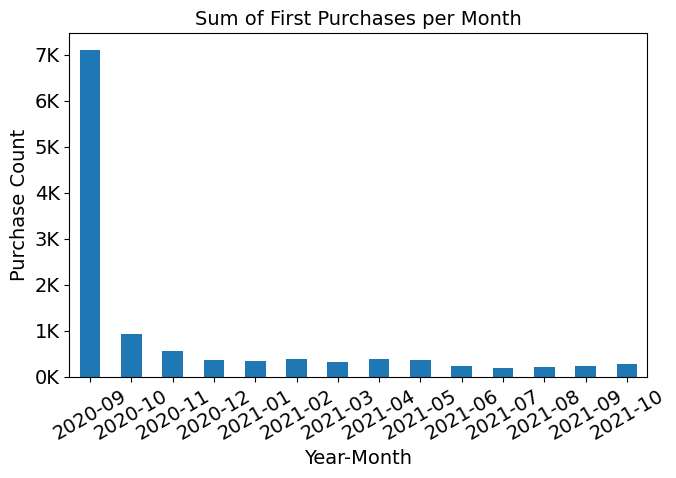

In [34]:
# Truncate to month-year
df1["first_purchase_month"] = df1["first_purchase_day"].dt.to_period('M') 
ax = df1.groupby('first_purchase_month').count()['first_purchase_day'].plot(kind='bar', figsize=(7, 5))

ylabels = [str(int(x)) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)

ax.set_title('Sum of First Purchases per Month')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Purchase Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()  # Ensure everything fits nicely
plt.show()

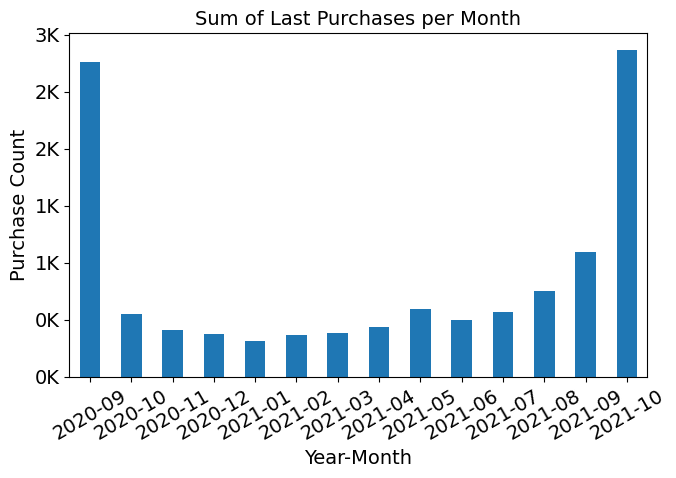

In [35]:
# Truncate to month-year
df1["last_purchase_month"] = df1["last_purchase_day"].dt.to_period('M') 
ax = df1.groupby('last_purchase_month').count()['last_purchase_day'].plot(kind='bar', figsize=(7, 5))

ylabels = [str(int(x)) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)

ax.set_title('Sum of Last Purchases per Month')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Purchase Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()  # Ensure everything fits nicely
plt.show()

1. **Acquisition vs. Retention:**
   - **Acquisition**: A lot of new customers made their first purchase in **September 2020**, but the number of new customers dropped in the following months.
   - **Retention**: After **September 2020**, fewer customers continued to make purchases, which might mean they stopped buying over time, or they "churned".<br><br>

2. **Customer Retention Trend:**
   - There was a **spike in last purchases** in **October 2021**, which is higher than in September 2021. This suggests that some customers who bought in 2020 are still buying or coming back in 2021.<br><br>

3. **Possible Seasonal Trends:**
   - The number of purchases varies each month, which could mean there are certain times of the year with more buying activity, possibly due to **seasons** or **special promotions/campaigns**.

In [36]:
# descriptive statistics for total_purchases_eur column
df1['total_purchases_eur'].describe()

count   11,968.00
mean       176.48
std        299.62
min          1.01
25%         32.38
50%         75.90
75%        196.33
max      7,979.62
Name: total_purchases_eur, dtype: float64

From the descriptive statistics, it is evident that the median is much lower than the mean, meaning that the distribution has a left skew (for example, most values are concentrated at lower amounts and a few extreme values exist). For this reason we visualize the distribution in a log scale on the y-axis.

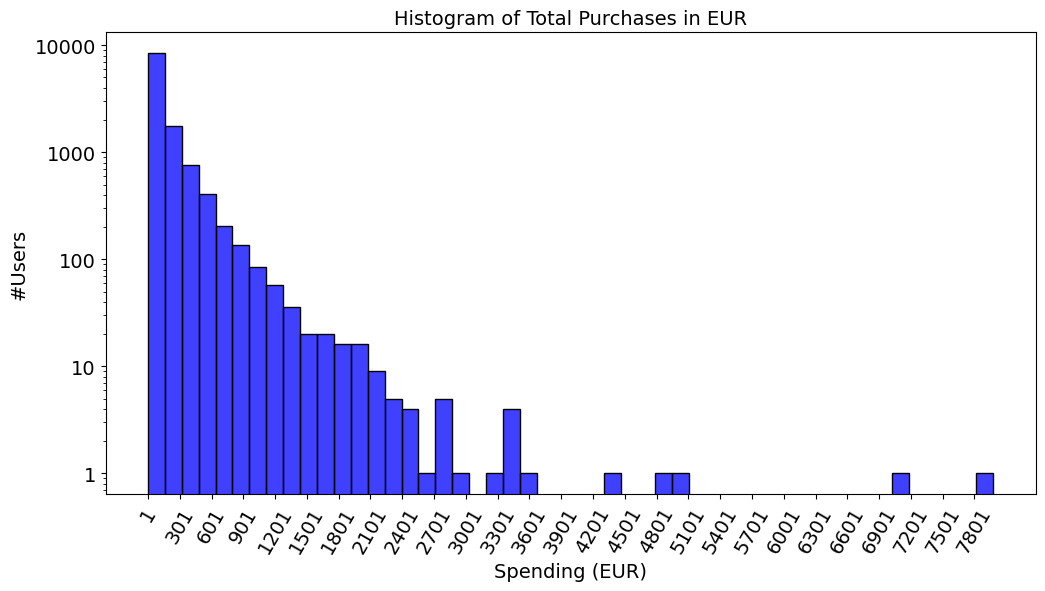

In [37]:
# Create the histogram for total_purchases_eur
plt.figure(figsize=(12, 6))
ax = sns.histplot(df1['total_purchases_eur'], bins=50, color='blue')

# Set the y-axis to log scale
plt.yscale('log')

plt.xticks(range(int(df1['total_purchases_eur'].min()), 
                int(df1['total_purchases_eur'].max()), 300))
plt.xticks(rotation=60) 

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Add titles and labels
plt.title('Histogram of Total Purchases in EUR')
plt.xlabel('Spending (EUR)')
plt.ylabel('#Users')

# Show the plot
plt.show()

The histogram shows the distribution of total purchases in EUR. Most purchases are concentrated at lower values, with a sharp decline in frequency as purchase amounts increase, indicating that the majority of customers spend smaller amounts. The presence of a few high-value purchases suggests a long-tail distribution, where a small number of customers account for significantly larger spending.

Text(0, 0.5, 'Purchase Frequency')

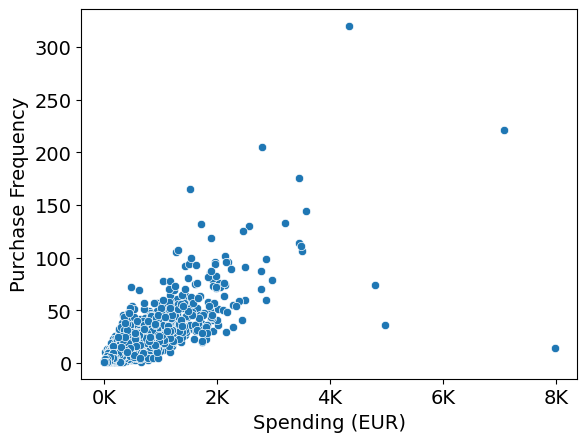

In [38]:
# scatter plot between total_purchases_eur and purchase_count
ax = sns.scatterplot(x='total_purchases_eur', y='purchase_count', data=df1)

xlabels = [str(int(x)) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

plt.xlabel('Spending (EUR)')
plt.ylabel('Purchase Frequency')

In [39]:
df1[['total_purchases_eur', 'purchase_count']].corr()

,total_purchases_eur,purchase_count
total_purchases_eur,1.00,0.86
purchase_count,0.86,1.00


The scatter plot visualizes the relationship between total purchase value (EUR) and purchase frequency. It shows a positive correlation (corr=.86), where higher purchase values are generally associated with increased frequency. The dense clustering at lower values indicates that most customers have both low purchase frequency and low total purchase values, while outliers in the upper range reflect a small number of high-value, high-frequency customers.

## RFM as Behavioral Segmentation 

We have 4 different types of segmentation: 

1. Demographic Segmentation: Divides the market based on demographic factors like age, gender, income, education, occupation, family size, etc.
2. Geographical Segmentation: Segmentation based on location, such as region, country, city, climate, or population density.
3. Psychographic Segmentation:  Focuses on lifestyle, personality traits, values, interests, and social status.
4. Behavioural Segmentation: Categorizes consumers based on their behavior, such as purchasing habits, usage rates, brand loyalty, or benefits sought.

Given the provided data, only the Behavioural Segmentation can be applied. The RFM (Recency, Frequency, and Monetary) is considered a behavioral segmentation method where those customer purchasing behavior's factors are considered:

1. Recency (R): How recently a customer made a purchase or interacted with the business.
2. Frequency (F): How often a customer makes a purchase or interacts with the business.
3. Monetary (M): How much money a customer spends on purchases.

For those factors for each user id we considered:
- Relative Recency: Days difference between the most recent purchase date within the dataset (data from September 2020 and October 2021) and the last user's purchase date 
- Relative Frequency: Number of purchases within the time span considered in the dataset
- Relative Monetary: Total purchase spending within the time span considered in the dataset

In [40]:
most_recent_purchase_date = df1['last_purchase_day'].max()

In [41]:
most_recent_purchase_date

Timestamp('2021-10-31 00:00:00')

In [42]:
rfm_df = df1[['user_id', 'registration_country_name', 'last_purchase_day', 'purchase_count', 
              'total_purchases_eur']].drop_duplicates()

In [43]:
rfm_df.size

107000

In [44]:
((rfm_df.size - rfm_df.dropna().size)/rfm_df.size)*100

44.163551401869164

When excluding the missing values from the dataset we lost only <~44% of data.

In [45]:
rfm_df.dropna(inplace=True)

In [46]:
rfm_df['recency'] = rfm_df.groupby('user_id')['last_purchase_day'].transform(
    lambda x: (most_recent_purchase_date - x.max()).days
)

In [47]:
rfm_df.rename(columns={'purchase_count': 'frequency', 'total_purchases_eur':'monetary'}, inplace=True)

In [48]:
rfm_df.groupby('registration_country_name')['monetary'].median()

registration_country_name
Georgia   32.38
Norway    74.89
Sweden    95.13
Name: monetary, dtype: float64

Customers in Norway, Georgia or Sweden have different spendings due to different income levels, economic conditions, or pricing strategies. Without normalization, customers from countries with higher average Monetary values will be disproportionately placed in higher RFM segments (e.g., high-value customers), while those from countries with lower Monetary values will appear to be lower-value customers, even if their Frequency and Recency are similar.

It makes sense to normalize the Monetary feature per country first, so that we can compare customers more fairly within each country. 

In [49]:
# normalizing monetary for each country
rfm_df['norm_monetary']= rfm_df.groupby('registration_country_name')['monetary'].transform(lambda x: x / x.mean())

In [50]:
# rfm_df = rfm_df[['user_id','recency', 'frequency', 'norm_monetary']]

In [51]:
rfm_df.head()

,user_id,registration_country_name,last_purchase_day,frequency,monetary,recency,norm_monetary
1,2,Norway,2021-09-02,1,38.46,59,0.22
2,3,Sweden,2021-05-25,19,631.49,159,3.06
7,8,Norway,2021-10-14,1,19.23,17,0.11
12,13,Norway,2021-10-27,19,587.97,4,3.43
13,14,Norway,2021-09-09,2,118.40,52,0.69


In [52]:
rfm_df[['recency', 'frequency', 'norm_monetary']].corr()

,recency,frequency,norm_monetary
recency,1.00,-0.39,-0.39
frequency,-0.39,1.00,0.90
norm_monetary,-0.39,0.90,1.00


There is a negative correlation between recency and both frequency (-0.39) and norm_monetary (-0.39), suggesting that customers who purchased recently tend to have lower frequency and lower monetary values. This is expected because customers who made recent purchases might not have purchased as often or spent as much over time.

Since there is a high positive correlation between **frequency** and **monetary** (0.9) and in order to avoid redudancy in the data we decided to combine them.

In [53]:
# scaling 
scaler = MinMaxScaler()

for column in ['frequency', 'norm_monetary']:
    scaled_column_name = f'{column}_scaled' 
    rfm_df[scaled_column_name] = scaler.fit_transform(rfm_df[[column]])

In [54]:
# Assigning weights for Frequency and Monetary
w_freq = 0.35 
w_monetary = 0.65

# Combining Frequency and Monetary into a weighted score
rfm_df['Freq_Mon_Combined'] = (w_freq * rfm_df['frequency_scaled'] + w_monetary * rfm_df['norm_monetary_scaled'])

In [55]:
# Computing RFM Scores
rfm_df['R_Score'] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['FM_Combined_Score'] = pd.qcut(rfm_df['Freq_Mon_Combined'], 5, labels=[1, 2, 3, 4, 5])

In [56]:
# Function to Assign Segments
def assign_segment(row):
    if row['R_Score'] >= 4 and row['FM_Combined_Score'] >= 4:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['FM_Combined_Score'] < 4:
        return 'Recent but Low Value'
    elif row['R_Score'] < 4 and row['FM_Combined_Score'] >= 4:
        return 'High Potential (Lost Big Spenders)'
    else:
        return 'At-Risk or Churned'

In [57]:
rfm_df['Customer_Segment'] = rfm_df.apply(assign_segment, axis=1)

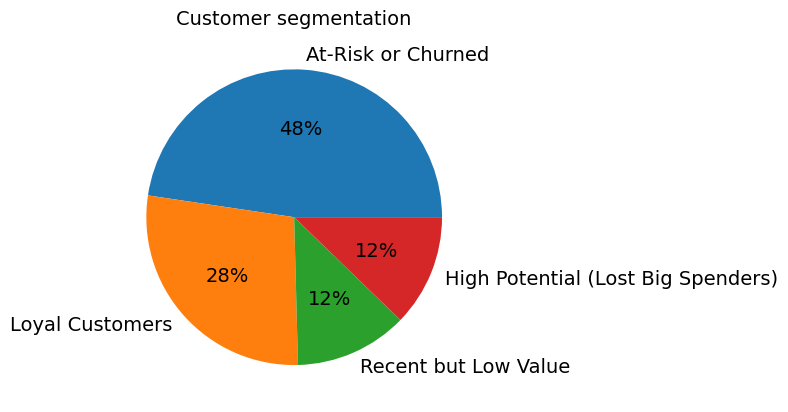

In [58]:
plt.pie(rfm_df.Customer_Segment.value_counts(),
        labels=rfm_df.Customer_Segment.value_counts().index,
        autopct='%.0f%%')
plt.title('Customer segmentation')
plt.show()

The pie chart shows a large proportion (48%) at risk of churn. While 28% are loyal, there's an opportunity to boost revenue by targeting the 12% of recent but low-value customers and re-engaging high-potential lost big spenders.

<Axes: xlabel='recency', ylabel='Count'>

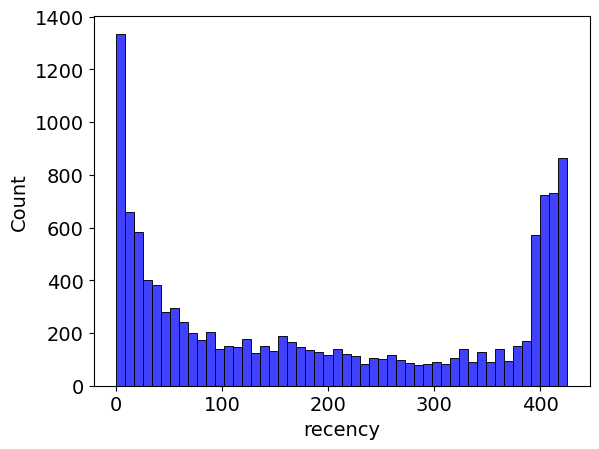

In [59]:
sns.histplot(rfm_df['recency'], bins=50, color='blue')

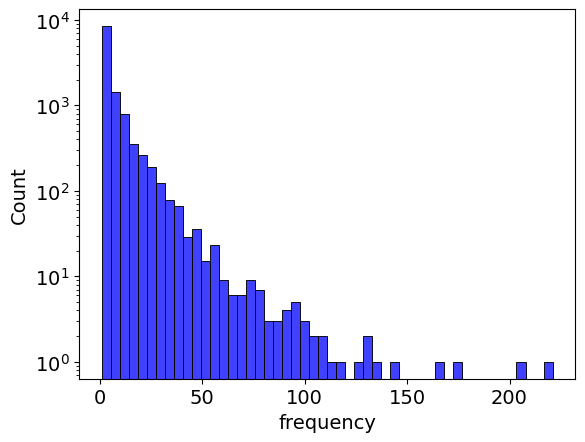

In [60]:
sns.histplot(rfm_df['frequency'], bins=50, color='blue')

# Set the y-axis to log scale
plt.yscale('log')

In [61]:
# Define your custom order
custom_order = ['Loyal Customers', 'High Potential (Lost Big Spenders)', 
                'Recent but Low Value', 'At-Risk or Churned']

# Set the 'Customer_Segment' column as a categorical variable with the custom order
rfm_df['Customer_Segment'] = pd.Categorical(rfm_df['Customer_Segment'], categories=custom_order, ordered=True)

In [62]:
# descriptive stats for the fsactors in RFM (median)
rfm_df.groupby('Customer_Segment')[['recency', 'frequency', 'monetary']].median()

,recency,frequency,monetary
Customer_Segment,,,
Loyal Customers,18.00,10.00,289.43
High Potential (Lost Big Spenders),189.50,6.00,185.70
Recent but Low Value,36.00,2.00,52.62
At-Risk or Churned,390.00,1.00,35.42


In [63]:
df_final = df1.merge(rfm_df.drop(columns='registration_country_name'), on='user_id', how='inner')

In [64]:
# calculating the share of active users for each country 
df_final.groupby('registration_country_name').user_id.nunique()/\
df_final.user_id.nunique()

registration_country_name
Georgia   0.13
Norway    0.46
Sweden    0.42
Name: user_id, dtype: float64

Also by looking only at the purchasing users, the share of data belonging to each country does change, manly for Sweden for which the share went from 38% to 42%. This is expected since, as we have seen before, Sweden has the highest share of purchasing users compared to the Norway and Georgia.

In [65]:
# calculatin the share of user having a valid payment method for the customer segment At-Risk or Churned
df_final[df_final['Customer_Segment'] == 'At-Risk or Churned']\
.user_has_valid_payment_method.value_counts(normalize=True)

user_has_valid_payment_method
True    0.56
False   0.44
Name: proportion, dtype: float64

As mentioned before, the customer segment __At-Risk or Churned__ has a higher percentage (56%) of an invalid payment method, meaning that maybe this factor can be a churn factor.

In [66]:
def calculate_share(df_final, list_columns):
    
    data = df_final.groupby('Customer_Segment')[list_columns].sum().reset_index()
    
    # Set 'Customer_Segment' as index for easier calculation
    data.set_index('Customer_Segment', inplace=True)

    # Calculate row totals
    data['total'] = data.sum(axis=1)

    # Calculate percentage for each store type
    perc_df = data.drop(columns='total').div(data['total'], axis=0) * 100
    
    return perc_df

In [67]:
service_perc_df = calculate_share(df_final=df_final , 
                                  list_columns=['purchase_count_delivery', 'purchase_count_takeaway'])

In [68]:
service_perc_df

,purchase_count_delivery,purchase_count_takeaway
Customer_Segment,,
Loyal Customers,94.08,5.92
High Potential (Lost Big Spenders),94.89,5.11
Recent but Low Value,92.14,7.86
At-Risk or Churned,92.01,7.99


**Insights about _service type (delivery vs takeway)_ for each customer segment:**

Across all segments, delivery is the dominant mode of purchase, accounting for over 90% of the activity in every group. This implies that customers strongly prefer convenience, likely valuing the ability to have products brought directly to them.

In [69]:
df_percent = calculate_share(df_final=df_final , 
                            list_columns=['general_merchandise', 'grocery', 
                                      'pet_supplies', 'restaurant', 'retail_store'])

In [70]:
df_percent

,general_merchandise,grocery,pet_supplies,restaurant,retail_store
Customer_Segment,,,,,
Loyal Customers,2.28,21.24,0.31,51.61,24.55
High Potential (Lost Big Spenders),2.61,18.67,0.19,59.30,19.24
Recent but Low Value,0.00,0.00,0.00,100.00,0.00
At-Risk or Churned,0.00,0.00,0.00,99.93,0.07


**Insights about _store type_ for each customer segment:**


The results reveal distinct purchasing patterns across customer segments:
1. **High Potential (Lost Big Spenders)** and **Loyal Customers** show a more balanced distribution, with significant purchases in the restaurant category, and notable engagement in retail stores and grocery  as well. 
2. **Recent but Low Value**  and **At-Risk or Churned** customers are entirely focused on restaurant purchases (100% and 99% respectively), indicating a strong interest in dining but no engagement with other store types.

In [71]:
df_percent2 = calculate_share(df_final=df_final , 
                            list_columns=['breakfast_purchases', 'lunch_purchases', 
                                                       'evening_purchases', 'dinner_purchases', 
                                                       'late_night_purchases',])

In [72]:
df_percent2

,breakfast_purchases,lunch_purchases,evening_purchases,dinner_purchases,late_night_purchases
Customer_Segment,,,,,
Loyal Customers,3.12,40.25,7.70,48.94,0.00
High Potential (Lost Big Spenders),3.45,36.31,8.78,51.45,0.00
Recent but Low Value,2.58,37.82,9.13,50.47,0.00
At-Risk or Churned,3.10,35.58,8.78,52.54,0.00


**Insights about _purchasing behavior during the day_ for each customer segment:**

The following analysis examines the purchasing behavior of different customer segments across various times of the day. The data highlights the distribution of purchases in breakfast, lunch, evening, dinner, and late-night categories for each segment.

We can see a general consistency in purchasing behavior across customer segments, with only slight variations in the proportions of purchases during different times of the day. The lunch and dinner purchases dominate in all segments, and zero engagement in the late night (after dinner) time.

For the __At-Risk or Churned__ customers the suggestion to the business stakeholders would be to send more deals/promotions during lunch or dinner, because the probability to redirect them back to the service is higher during this time of the day.

In [73]:
df_final.groupby('Customer_Segment')[['preferred_device']].value_counts(normalize=True)

Customer_Segment                    preferred_device
Loyal Customers                     ios                0.45
                                    android            0.33
                                    web                0.22
High Potential (Lost Big Spenders)  ios                0.43
                                    android            0.32
                                    web                0.25
Recent but Low Value                ios                0.48
                                    android            0.39
                                    web                0.13
At-Risk or Churned                  ios                0.43
                                    android            0.34
                                    web                0.23
Name: proportion, dtype: float64

**Insights about _preferred device_ for each customer segment:**

The above analysis shows the proportion of preferred devices across customer segments. 

iOS is the dominant platform across all groups, particularly among high-value and loyal customers, while Android sees its highest share in the **Recent but Low Value** segment (39%). Web usage is relatively low in all segments, with the lowest engagement in newer, lower-value customers, indicating a strong preference for mobile platforms.

These insights highlight the importance of prioritizing mobile channels, particularly iOS, while exploring strategies to enhance engagement on Android and web platforms.